# 未整理

## 解析Mnist数据集

trainingNumber labelShape imageShape
60000 (60000,) (60000, 784)
5


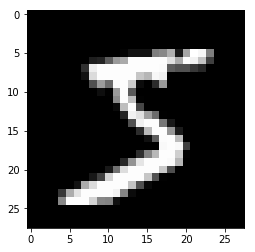

testingNumber labelShape imageShape
10000 (10000,) (10000, 784)
7


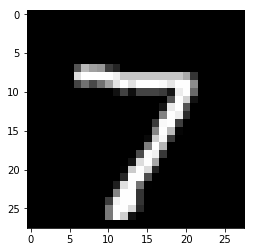

In [64]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import os

# Function: transform binary-represented image labels into decimal-represented (array) image labels
# http://yann.lecun.com/exdb/mnist/  ：minst数据集描述
# input: binary file  
# output: the number of images and the array represented image labels
def read_labels(enter):
    data=open(enter, 'rb').read()
    head=struct.unpack_from('>II',data,0)
    number=head[1]
    numString='>'+str(number)+'B'
    offset=struct.calcsize('>II')
    labels=struct.unpack_from(numString, data, offset)
    labels=np.reshape(labels, [number])
    return number, labels

# Function: transfer binary-represented image into decimal-represented (array) image 
# input: binary file
# output: the number of images and the array represented image 
def read_images(enter):
    data=open(enter, 'rb').read()
    head=struct.unpack_from('>IIII',data,0)
    number=head[1]
    rows=head[2]
    columns=head[3]
    offset=struct.calcsize('>IIII')
    numString='>'+str(number*rows*columns)+'B'
    images=struct.unpack_from(numString, data, offset)
    images=np.reshape(images, [number, rows*columns])
    return number, images
    

# pwd=os.getcwd()
# print(pwd)
trainNum, trainL=read_labels('./data/train-labels.idx1-ubyte')
_, trainI=read_images('./data/train-images.idx3-ubyte')
testNum, testL=read_labels('./data/t10k-labels.idx1-ubyte')
_, testI=read_images('./data/t10k-images.idx3-ubyte')
print("trainingNumber","labelShape", "imageShape")
print(trainNum, trainL.shape, trainI.shape)
print(trainL[0])
fig=plt.figure()
plotwindow = fig.add_subplot(111)
plt.imshow(trainI[0,].reshape(28,28) , cmap='gray')
plt.show()
print("testingNumber", "labelShape", "imageShape")
print(testNum, testL.shape, testI.shape)
print(testL[0])
fig=plt.figure()
plotwindow = fig.add_subplot(111)
plt.imshow(testI[0,].reshape(28,28) , cmap='gray')
plt.show()


# keras下载的数据集存放在/Users/xieliang/.kears/dataset中，command+shift+.可以显示隐藏文件
# Keras下载的预训练模型在一下目录中：./kears/models

## scope

In [17]:
import tensorflow as tf
tf.reset_default_graph()

# tf.name_scope:
with tf.name_scope("a_name_scope"):
    initializer = tf.constant_initializer(value=1)
    var1 = tf.get_variable(name='var1', shape=[1], dtype=tf.float32, initializer=initializer)
    var2 = tf.Variable(name='var2', initial_value=[2], dtype=tf.float32)
    var21 = tf.Variable(name='var2', initial_value=[2.1], dtype=tf.float32)
    var22 = tf.Variable(name='var2', initial_value=[2.2], dtype=tf.float32)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(var1.name)        # var1:0
    print(sess.run(var1))   # [ 1.]
    print(var2.name)        # a_name_scope/var2:0
    print(sess.run(var2))   # [ 2.]
    print(var21.name)       # a_name_scope/var2_1:0
    print(sess.run(var21))  # [ 2.0999999]
    print(var22.name)       # a_name_scope/var2_2:0
    print(sess.run(var22))  # [ 2.20000005]
        
# 可以看出使用 tf.Variable() 定义的时候, 虽然 name 都一样, 但是为了不重复变量名, Tensorflow 输出的变量名并不是一样的. 
# 所以, 本质上 var2, var21, var22 并不是一样的变量. 而另一方面, 使用tf.get_variable()定义的变量不会被tf.name_scope()
# 当中的名字所影响.



# tf.variale_scope:
with tf.variable_scope("a_variable_scope") as scope:
    initializer = tf.constant_initializer(value=3)
    var3 = tf.get_variable(name='var3', shape=[1], dtype=tf.float32, initializer=initializer)
    scope.reuse_variables()
    var3_reuse = tf.get_variable(name='var3')
    var4 = tf.Variable(name='var4', initial_value=[4], dtype=tf.float32)
    var4_reuse = tf.Variable(name='var4', initial_value=[4], dtype=tf.float32)
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(var3.name)            # a_variable_scope/var3:0
    print(sess.run(var3))       # [ 3.]
    print(var3_reuse.name)      # a_variable_scope/var3:0
    print(sess.run(var3_reuse)) # [ 3.]
    print(var4.name)            # a_variable_scope/var4:0
    print(sess.run(var4))       # [ 4.]
    print(var4_reuse.name)      # a_variable_scope/var4_1:0
    print(sess.run(var4_reuse)) # [ 4.]
    
# 使用 tf.variable_scope(), 并搭配 tf.get_variable() 这种方式产生和提取变量，可以重复利用变量. 不像 tf.Variable() 每次都会产生新的变量, 
# tf.get_variable() 如果遇到了同样名字的变量时, 它会单纯的提取这个同样名字的变量(避免产生新变量). 

var1:0
[1.]
a_name_scope/var2:0
[2.]
a_name_scope/var2_1:0
[2.1]
a_name_scope/var2_2:0
[2.2]
a_variable_scope/var3:0
[3.]
a_variable_scope/var3:0
[3.]
a_variable_scope/var4:0
[4.]
a_variable_scope/var4_1:0
[4.]


## 冻结层

In [92]:
# 只训练f_2的变量

import tensorflow as tf
import numpy as np
tf.reset_default_graph()

np.random.seed(1)
tf.set_random_seed(2)

x=tf.placeholder("float",shape=[10,2])
y=tf.placeholder("float",shape=[10,4])

# with tf.name_scope("f_1"):
w1=tf.Variable(tf.random_normal(shape=[2,16]))
b1=tf.Variable(tf.constant(0.1,shape=[16]))
h1=tf.nn.relu(tf.matmul(x,w1)+b1)
                   
with tf.name_scope("f_2"):
    w2=tf.Variable(tf.random_normal(shape=[16,4]))
    b2=tf.Variable(tf.constant(0.1,shape=[4]))
    h2=tf.nn.softmax(tf.matmul(h1,w2)+b2)
                   
cross_entropy=-tf.reduce_sum(y*tf.log(h2))
cost=tf.reduce_mean(cross_entropy)
output_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='f_2')
train_step=tf.train.GradientDescentOptimizer(0.05).minimize(cost,var_list=output_vars)
                
                   
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    X=np.random.normal(size=[10,2])
    Y_=np.random.randint(0,4,size=[10])
    Y=np.eye(4)[Y_] 
    print("w1",sess.run(w1))
    print("w2",sess.run(w2))
    for i in range(100):
        if i%50==0:
            print("w1",sess.run(w1))
            print("w2",sess.run(w2))
        sess.run(train_step,feed_dict={x:X,y:Y})
        
    print(tf.trainable_variables())
                   
    summary_writer = tf.summary.FileWriter("/Users/xieliang/tensorboard/log", sess.graph)

w1 [[-0.39120236 -1.1576606   0.87334764 -0.7303882   0.07501176  1.620321
   1.8835862  -1.3954105   0.8211904   0.29821634  0.5768454   0.6407048
   1.6286273   0.3706698   1.439593   -0.15120259]
 [ 1.0260885   1.1177633  -0.19195524  1.7406971  -1.310152   -0.4836808
  -0.2156518  -1.2248985   0.23038463  2.2014184  -0.45303607 -1.0778311
   0.5504739  -0.86361825 -0.22194642 -2.0931287 ]]
w2 [[ 0.6234362  -0.12177572 -0.62886524 -0.16651055]
 [-1.1038439   2.1849794  -0.51562107  1.4062196 ]
 [-1.2453713  -0.8040709   1.464686   -0.83139896]
 [-0.13845463  0.9504034   0.18048692 -0.8323389 ]
 [ 1.1970384   2.8357759   0.20434435  2.143964  ]
 [-0.4596095  -1.3601769   0.2694022   0.29500097]
 [ 0.18047892 -0.50541294 -0.64386934 -1.9357166 ]
 [-1.1468465  -0.269284    0.30048028  0.4743608 ]
 [-0.40860426 -1.6375821   1.3470358  -0.6510921 ]
 [-1.165711    1.6415719  -1.0415775  -1.0938847 ]
 [-0.6328194  -0.14331923  0.28803518 -1.9924806 ]
 [ 0.14581898  1.0857391   0.54979885  

In [70]:
np.random.seed(1)
print(np.random.randint(0,4,size=[10]))

[1 3 0 0 3 1 3 1 3 0]


## 构建mlp，保存模型

In [13]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import os

#多个cell重置graph
tf.reset_default_graph()
#mnist是一个轻量级的类。它以Numpy数组的形式存储着训练、校验和测试数据集。同时提供了一个函数，用于在迭代中获得minibatch
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# 输入为二维张量，None表示第0维可以为任何值，即表示输入的batch
x=tf.placeholder("float",name="x", shape=[None, 784])
W=tf.Variable(tf.zeros([784,10]),name="W")
b=tf.Variable(tf.zeros([10]),name="b")
# +b 第一维不够自动扩展（matmul（x,W）和b的第0维长度必须相同）
y=tf.nn.softmax(tf.matmul(x,W)+b)
y_=tf.placeholder("float",name="y_", shape=[None,10])
# *为hadamard积
cross_entropy=-tf.reduce_sum(y_*tf.log(y))
cost=tf.reduce_mean(cross_entropy)
# training cross_entropy instead of cost(先求导后平均和先平均后求导是等价的)
train_step=tf.train.GradientDescentOptimizer(0.005).minimize(cross_entropy)
# testing
# argmax(_y,1)指按照第1维找最大值的下标
correct_prediction=tf.equal(tf.argmax(y_,1), tf.argmax(y, 1))
# equal()返回布尔值，将其转化为float
accuracy=tf.reduce_mean(tf.cast(correct_prediction, "float"),name="accuracy")
# 最多保存模型的一次迭代结果
saver=tf.train.Saver(max_to_keep=1)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(2000):
        batch_xs, batch_ys =mnist.train.next_batch(100)
        batch_xs_val, batch_ys_val =mnist.train.next_batch(100)
        feed_dict_tra={x: batch_xs, y_: batch_ys}
        feed_dict_val={x: batch_xs_val, y_: batch_ys_val}
        sess.run(train_step, feed_dict=feed_dict_tra)
        #每1000个iteration保存模型,graph只需保存一次
        epoch=int(i/600)
        if i%1000==0: 
            if epoch>0:
                saver.save(sess,'./model/mlp-model',write_meta_graph=False)
                print(sess.run(accuracy, feed_dict={x: mnist.train.images, y_:  mnist.train.labels}))
                print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))
            else:
                saver.save(sess,'./model/mlp-model',write_meta_graph=True)
        #每个epoch打印训练信息
        if i%(600)==0:
            acc=sess.run(accuracy,feed_dict=feed_dict_tra)
            acc_val=sess.run(accuracy,feed_dict=feed_dict_val)
            val_loss=sess.run(cost,feed_dict=feed_dict_val)
            msg = "Training Epoch {0}, iterations: {1}, Training Accuracy: {2:>6.1%}, Validation Accuracy: {3:>6.1%},  Validation Loss: {4:.3f}"
            print(msg.format(epoch,i,acc,acc_val,val_loss))
            
    #print(batch_xs.shape)
    print('model saved into'+' '+str(os.getcwd())+'/model/mlp-model')
    print(sess.run(accuracy, feed_dict={x: mnist.train.images, y_:  mnist.train.labels}))
    print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))
    summary_writer = tf.summary.FileWriter("/Users/xieliang/tensorboard/log", sess.graph)
    

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Training Epoch 0, iterations: 0, Training Accuracy:  32.0%, Validation Accuracy:  21.0%,  Validation Loss: 210.092
Training Epoch 1, iterations: 600, Training Accuracy:  95.0%, Validation Accuracy:  94.0%,  Validation Loss: 24.184
0.91712725
0.921
Training Epoch 2, iterations: 1200, Training Accuracy:  97.0%, Validation Accuracy:  92.0%,  Validation Loss: 33.924
Training Epoch 3, iterations: 1800, Training Accuracy:  95.0%, Validation Accuracy:  94.0%,  Validation Loss: 18.485
model saved into /Users/xieliang/notebook/note/model/mlp-model
0.9200909
0.9184


## 多graph交互

In [87]:
import tensorflow as tf
tf.reset_default_graph()
# 默认graph
m=[1,2]
x=tf.placeholder("int32",shape=[2])
a=tf.constant([1,2])
r=a+x

# 新建graph
g1=tf.Graph()
with g1.as_default():
    b=tf.constant([5,6])
    c=m+b
    


sess1=tf.Session(graph=tf.get_default_graph())
sess2=tf.Session(graph=g1)
out=sess1.run(r,feed_dict={x:sess2.run(c)}) 
print(out)
    
print(x.graph is g1)
print(x.graph is tf.get_default_graph())
print(g1.version)
summary_writer = tf.summary.FileWriter("/Users/xieliang/tensorboard/log", sess.graph)

[ 7 10]
False
True
3


## 载入mlp模型：graph+variable

In [3]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

#jupyter的cell不是互相独立的，需要重置graph
tf.reset_default_graph()

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
graph=tf.get_default_graph()
sess3=tf.Session()
new_saver=tf.train.import_meta_graph('./model/mlp-model.meta')
new_saver.restore(sess3,tf.train.latest_checkpoint('./model/'))
accuracy=graph.get_tensor_by_name("accuracy:0")
x=graph.get_tensor_by_name("x:0")
y_=graph.get_tensor_by_name("y_:0")
print(sess3.run(accuracy,feed_dict={x:mnist.train.images,y_:mnist.train.labels}))
print(sess3.run(accuracy,feed_dict={x:mnist.test.images,y_:mnist.test.labels}))

tf.summary.FileWriter("/Users/xieliang/tensorboard/log/", sess3.graph)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Restoring parameters from ./model/mlp-model
0.91712725
0.921


## 载入mlp模型：variable

In [5]:
import tensorflow as tf
# from tensorflow.examples.tutorials.mnist import input_data
  
tf.reset_default_graph()
# mnist=input_data.read_data_sets("MNIST_data/",one_hot=True)
# x=tf.placeholder("float",shape=[None,784])
# y_=tf.placeholder("float",shape=[None,10])
# #只载入模型变量，需要手动构建网络，且所有Variable的名字需对应上
# W=tf.Variable(tf.zeros([784,10]),name="W")
# b=tf.Variable(tf.zeros([10]),name="b")
# y=tf.nn.softmax(tf.matmul(x,W)+b)
# cross_entropy=-tf.reduce_sum(y_*tf.log(y))
# cost=tf.reduce_mean(cross_entropy)
# train_step=tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
# correct_prediction=tf.equal(tf.argmax(y,1),tf.argmax(y_,1))
# accuracy=tf.reduce_mean(tf.cast(correct_prediction,"float"))

sess=tf.Session()
saver=tf.train.Saver()
saver.restore(sess,tf.train.latest_checkpoint('./model/'))
# print(sess.run(accuracy,feed_dict={x:mnist.train.images,y_:mnist.train.labels}))
# print(sess.run(accuracy,feed_dict={x:mnist.test.images,y_:mnist.test.labels}))
# print(sess.run(train_step,feed_dict={x:mnist.train.images,y_:mnist.train.labels}))

tf.summary.FileWriter("/Users/xieliang/tensorboard/log/", sess.graph)


ValueError: No variables to save

## 构建CNN, Tensorboard

In [45]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

tf.reset_default_graph()
mnist=input_data.read_data_sets("MNIST_data/",one_hot=True)
x=tf.placeholder("float",shape=[None,784])
y_=tf.placeholder("float",shape=[None,10])

x_image=tf.reshape(x,[-1,28,28,1])
W_conv1=tf.Variable(tf.truncated_normal(shape=[5,5,1,32],mean=0,stddev=0.1))
b_conv1=tf.Variable(tf.constant(0.1,shape=[32]))
h_conv1=tf.nn.relu(tf.nn.conv2d(x_image,W_conv1,strides=[1,1,1,1],padding='SAME')+b_conv1)
h_pool1=tf.nn.max_pool(h_conv1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

W_conv2=tf.Variable(tf.truncated_normal(shape=[5,5,32,64],mean=0,stddev=0.1))
b_conv2=tf.Variable(tf.constant(0.1,shape=[64]))
h_conv2=tf.nn.relu(tf.nn.conv2d(h_pool1,W_conv2,strides=[1,1,1,1],padding='SAME')+b_conv2)
h_pool2=tf.nn.max_pool(h_conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

W_fc1=tf.Variable(tf.truncated_normal(shape=[7*7*64,1024],mean=0,stddev=0.1))
b_fc1=tf.Variable(tf.constant(0.1,shape=[1024]))
h_pool2_flat=tf.reshape(h_pool2,[-1,7*7*64])
h_fc1=tf.nn.relu(tf.matmul(h_pool2_flat,W_fc1)+b_fc1)

keep_prob=tf.placeholder("float")
h_fc1_drop=tf.nn.dropout(h_fc1,keep_prob)

W_fc2=tf.Variable(tf.truncated_normal(shape=[1024,10],mean=0,stddev=0.1))
b_fc2=tf.Variable(tf.constant(0.1,shape=[10]))
y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop,W_fc2)+b_fc2)

cross_entropy=-tf.reduce_sum(y_*tf.log(y_conv))
tf.summary.histogram("cross_entropy",cross_entropy)
train_step=tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction=tf.equal(tf.argmax(y_,1),tf.argmax(y_conv,1))
accuracy=tf.reduce_mean(tf.cast(correct_prediction,"float"))
tf.summary.scalar("accuracy",accuracy)
writer = tf.summary.FileWriter("/Users/xieliang/tensorboard")
summaries = tf.summary.merge_all()

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    for i in range(1000):
        batch=mnist.train.next_batch(50)
        if i%100==0:
            train_accuracy=accuracy.eval(feed_dict={x:batch[0],y_:batch[1],keep_prob:1.0})
            print("step %d, validation accuracy %g"%(i, train_accuracy))
        summ,_=sess.run([summaries,train_step],feed_dict={x:batch[0],y_:batch[1],keep_prob:0.5})
        writer.add_summary(summ,i)
    print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
    
#在py3.6环境下，终端输入：tensorboard --logdir="/Users/xieliang/tensorboard"
# 在浏览器中输入localhost:6006

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
step 0, validation accuracy 0.14
step 100, validation accuracy 0.82
step 200, validation accuracy 0.94
step 300, validation accuracy 0.96
step 400, validation accuracy 0.94
step 500, validation accuracy 0.96
step 600, validation accuracy 0.96
step 700, validation accuracy 0.94
step 800, validation accuracy 0.94
step 900, validation accuracy 1
test accuracy 0.964


## 共享变量

In [6]:
import tensorflow as tf

tf.reset_default_graph()

x1=tf.placeholder("float",[1,2,2,3])
x2=tf.placeholder("float",[1,2,2,3])

def conv_relu(input, kernel_shape, bias_shape):
    weights=tf.get_variable("weights",kernel_shape,initializer=tf.random_normal_initializer())
    biases=tf.get_variable("biases",bias_shape,initializer=tf.constant_initializer(0.1))
    conv=tf.nn.conv2d(input,weights,strides=[1,1,1,1],padding="SAME")
    return tf.nn.relu(conv+biases)

def my_filter(input):
    with tf.variable_scope("conv1"):
        relu1=conv_relu(input,[1,1,3,2],[2])
    with tf.variable_scope("conv2"):
        return conv_relu(relu1,[1,1,2,1],[1])
    
with tf.variable_scope("my_filter",reuse=tf.AUTO_REUSE) as scope:
    result1=my_filter(x1)
#     scope.reuse_variables()
    result2=my_filter(x2)
    
sess=tf.Session()
sess.run(tf.global_variables_initializer())
print(sess.run(result1,feed_dict={x1:[[[[1.0,1.0,1.0],[1.0,1.0,1.0]],[[1.0,1.0,1.0],[1.0,1.0,1.0]]]]}))
print(sess.run(result2,feed_dict={x2:[[[[1.0,1.0,1.0],[1.0,1.0,1.0]],[[1.0,1.0,1.0],[1.0,1.0,1.0]]]]}))
summary_writer = tf.summary.FileWriter("/Users/xieliang/tensorboard/log", sess.graph)
# tensorboard --logdir="/Users/xieliang/tensorboard/log"

[[[[0.]
   [0.]]

  [[0.]
   [0.]]]]
[[[[0.]
   [0.]]

  [[0.]
   [0.]]]]


## 不使用共享变量

In [6]:
import tensorflow as tf

tf.reset_default_graph()

x1=tf.placeholder("float",[1,2,2,3])
x2=tf.placeholder("float",[1,2,2,3])

def my_filter(input):
    w1=tf.Variable(tf.truncated_normal([1,1,3,2],mean=0,stddev=0.1))
    b1=tf.Variable(tf.constant(0.1,shape=[2]))
    relu1=tf.nn.relu(tf.nn.conv2d(input,w1,strides=[1,1,1,1],padding="SAME")+b1)
    w2=tf.Variable(tf.truncated_normal([1,1,2,1],mean=0,stddev=0.1))
    b2=tf.Variable(tf.constant(0.1,shape=[1]))
    conv2=tf.nn.conv2d(relu1,w2,strides=[1,1,1,1],padding="SAME")
    return tf.nn.relu(conv2+b2)

# 调用两次函数（函数内定义了graph），构建两张graph
result1=my_filter(x1)
result2=my_filter(x2)

sess=tf.Session()
sess.run(tf.global_variables_initializer())

print(sess.run(result1,feed_dict={x1:[[[[1.0,1.0,1.0],[1.0,1.0,1.0]],[[1.0,1.0,1.0],[1.0,1.0,1.0]]]]}))
print(sess.run(result2,feed_dict={x2:[[[[1.0,1.0,1.0],[1.0,1.0,1.0]],[[1.0,1.0,1.0],[1.0,1.0,1.0]]]]}))
summary_writer = tf.summary.FileWriter("/Users/xieliang/tensorboard/log", sess.graph)

[[[[ 0.09099288]
   [ 0.09099288]]

  [[ 0.09099288]
   [ 0.09099288]]]]
[[[[ 0.09253512]
   [ 0.09253512]]

  [[ 0.09253512]
   [ 0.09253512]]]]


In [7]:
import tensorflow as tf

tf.reset_default_graph()

def my_filter(input):
    w1=tf.Variable(tf.truncated_normal([1,1,3,2],mean=0,stddev=0.1))
    b1=tf.Variable(tf.constant(0.1,shape=[2]))
    relu1=tf.nn.relu(tf.nn.conv2d(input,w1,strides=[1,1,1,1],padding="SAME")+b1)
    w2=tf.Variable(tf.truncated_normal([1,1,2,1],mean=0,stddev=0.1))
    b2=tf.Variable(tf.constant(0.1,shape=[1]))
    conv2=tf.nn.conv2d(relu1,w2,strides=[1,1,1,1],padding="SAME")
    return tf.nn.relu(conv2+b2)

# 仅调用一次函数，构建一张graph(与上面产生相同效果，但只生成一张graph)
x1=tf.placeholder("float",[1,2,2,3])
result1=my_filter(x1)

sess=tf.Session()
sess.run(tf.global_variables_initializer())

print(sess.run(result1,feed_dict={x1:[[[[1.0,1.0,1.0],[1.0,1.0,1.0]],[[1.0,1.0,1.0],[1.0,1.0,1.0]]]]}))
print(sess.run(result1,feed_dict={x1:[[[[1.0,3.0,1.0],[1.0,5.0,1.0]],[[1.0,8.0,1.0],[1.0,1.0,1.0]]]]}))
summary_writer = tf.summary.FileWriter("/Users/xieliang/tensorboard/log", sess.graph)

[[[[ 0.1238339]
   [ 0.1238339]]

  [[ 0.1238339]
   [ 0.1238339]]]]
[[[[ 0.15226555]
   [ 0.17777762]]

  [[ 0.21604572]
   [ 0.1238339 ]]]]


## 可视化(Figure)

### 损失函数

a= 1.2139553 b= 2.5095341


<IPython.core.display.Javascript object>


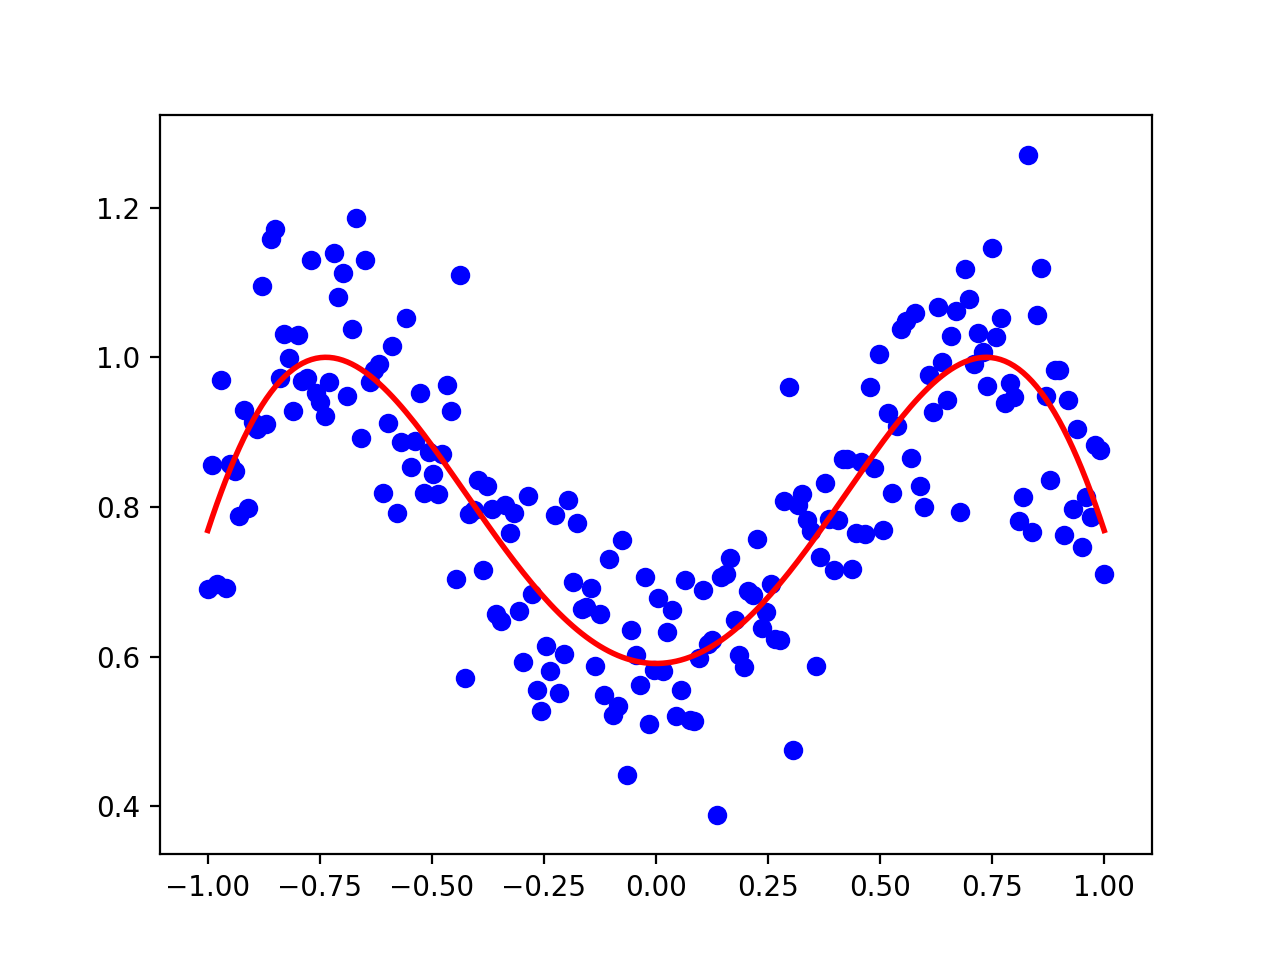

<IPython.core.display.Javascript object>


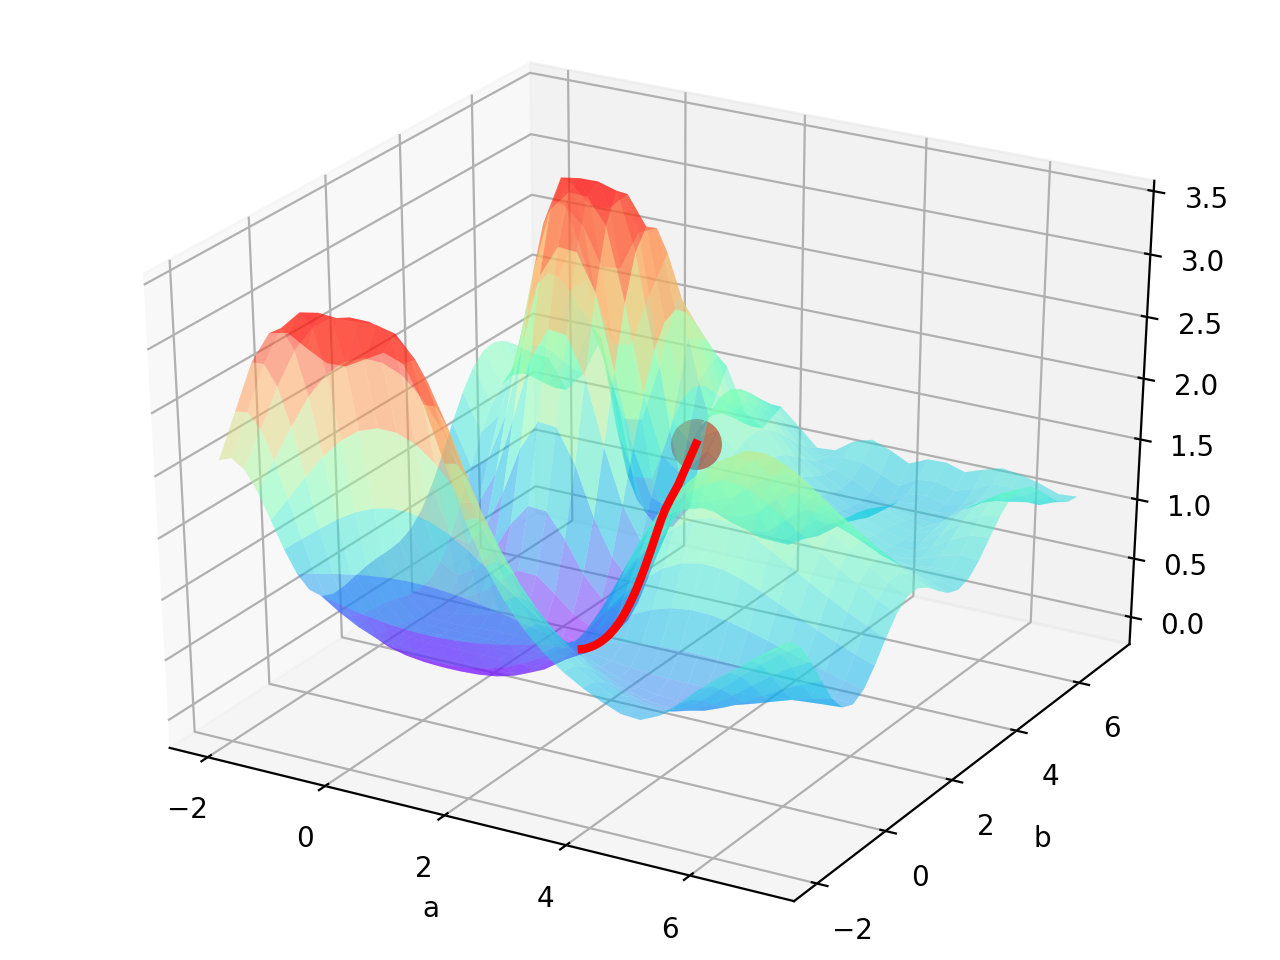

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

LR = 0.1
REAL_PARAMS = [1.2, 2.5]
INIT_PARAMS = [[5, 4],
               [5, 1],
               [2, 4.5]][2]


x = np.linspace(-1, 1, 200, dtype=np.float32)   # x data

# Test (1): Visualize a simple linear function with two parameters,
# you can change LR to 1 to see the different pattern in gradient descent.

# y_fun = lambda a, b: a * x + b
# tf_y_fun = lambda a, b: a * x + b


# Test (2): Using Tensorflow as a calibrating tool for empirical formula like following.

# y_fun = lambda a, b: a * x**3 + b * x**2
# tf_y_fun = lambda a, b: a * x**3 + b * x**2


# Test (3): Most simplest two parameters and two layers Neural Net, and their local & global minimum,
# you can try different INIT_PARAMS set to visualize the gradient descent.

y_fun = lambda a, b: np.sin(b*np.cos(a*x))
tf_y_fun = lambda a, b: tf.sin(b*tf.cos(a*x))

noise = np.random.randn(200)/10
y = y_fun(*REAL_PARAMS) + noise         # target

# tensorflow graph
a, b = [tf.Variable(initial_value=p, dtype=tf.float32) for p in INIT_PARAMS]
pred = tf_y_fun(a, b)
mse = tf.reduce_mean(tf.square(y-pred))
train_op = tf.train.GradientDescentOptimizer(LR).minimize(mse)

a_list, b_list, cost_list = [], [], []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for t in range(400):
        a_, b_, mse_ = sess.run([a, b, mse])
        a_list.append(a_); b_list.append(b_); cost_list.append(mse_)    # record parameter changes
        result, _ = sess.run([pred, train_op])                          # training


# visualization codes:
# %matplotlib inline
%matplotlib notebook
print('a=', a_, 'b=', b_)
plt.figure(1)
plt.scatter(x, y, c='b')    # plot data
plt.plot(x, result, 'r-', lw=2)   # plot line fitting
# 3D cost figure
fig = plt.figure(2); ax = Axes3D(fig)
a3D, b3D = np.meshgrid(np.linspace(-2, 7, 30), np.linspace(-2, 7, 30))  # parameter space
cost3D = np.array([np.mean(np.square(y_fun(a_, b_) - y)) for a_, b_ in zip(a3D.flatten(), b3D.flatten())]).reshape(a3D.shape)
ax.plot_surface(a3D, b3D, cost3D, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'), alpha=0.5)
ax.scatter(a_list[0], b_list[0], zs=cost_list[0], s=300, c='r')  # initial parameter place
ax.set_xlabel('a'); ax.set_ylabel('b')
ax.plot(a_list, b_list, zs=cost_list, zdir='z', c='r', lw=3)    # plot 3D gradient descent
plt.show()

## Hyperopt超参数自动调优

### 直接优化变量

In [29]:
from hyperopt import  hp,fmin, rand,Trials

def q (args) :
    x, y = args
    return x**2-2*x+1 + y**2

# 函space第一个参数是标签，每个超参数在参数空间内必须具有独一无二的标签，该标签与q函数中的参数一一对应
# hp.randint('x',5): x在[0,4]区间内的整数中随机检索
# hp.uniform('x',0,10): 指定了参数的分布为[0,10]的均匀分布
# ...
space = [hp.randint('m', 5), hp.randint('n', 5)]

trials=Trials()

# 检索10次，检索信息存储在trials对象中
# 搜索算法：1)随机搜索：rand.seggest；2）TPE搜索：tpe.suggest ( Tree of Parzen Estimators) 3)模拟退火:anneal.suggest
best = fmin(q,space,algo=rand.suggest,max_evals=10,trials=trials)

print(best)
# print(trials.trials)
print(trials.statuses())
print(trials.losses())
print(trials.best_trial)
print(trials.vals)

{'m': 1, 'n': 1}
['ok', 'ok', 'ok', 'ok', 'ok', 'ok', 'ok', 'ok', 'ok', 'ok']
[4.0, 1.0, 4.0, 25.0, 2.0, 2.0, 10.0, 9.0, 4.0, 1.0]
{'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': 1.0, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'m': [1], 'n': [1]}, 'vals': {'m': [1], 'n': [1]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2019, 3, 22, 6, 44, 53, 470000), 'refresh_time': datetime.datetime(2019, 3, 22, 6, 44, 53, 470000)}
{'m': [1, 1, 1, 4, 2, 0, 4, 4, 1, 0], 'n': [2, 1, 2, 4, 1, 1, 1, 0, 2, 0]}


### 优化超参数

In [26]:
#coding:utf-8
from hyperopt import fmin, tpe, hp, rand
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn import datasets

# SVM的三个超参数：C为惩罚因子，kernel为核函数类型，gamma为核函数的额外参数（对于不同类型的核函数有不同的含义）
# 有别于传统的网格搜索（GridSearch），这里只需要给出最优参数的概率分布即可，而不需要按照步长把具体的值给一个个枚举出来
parameter_space_svc ={
    # loguniform表示该参数取对数后符合均匀分布
    'C':hp.loguniform("C", np.log(1), np.log(100)),
    'kernel':hp.choice('kernel',['rbf','poly']),
    'gamma': hp.loguniform("gamma", np.log(0.001), np.log(0.1)),
}

# 鸢尾花卉数据集，是一类多重变量分析的数据集
# 通过花萼长度，花萼宽度，花瓣长度，花瓣宽度4个属性预测鸢尾花卉属于（Setosa，Versicolour，Virginica）三个种类中的哪一类
iris = datasets.load_digits()

#--------------------划分训练集和测试集--------------------
train_data = iris.data[0:1300]
train_target = iris.target[0:1300]
test_data = iris.data[1300:-1]
test_target = iris.target[1300:-1]
#-----------------------------------------------------------

# 计数器，每一次参数组合的枚举都会使它加1
count = 0

def function(args):
    print(args)

    # **arg表示从space中传入（长度可不确定）dictionary,字典的key必须与函数的参数名称一一对应
    clf = svm.SVC(**args)

    # 训练模型
    clf.fit(train_data,train_target)

    # 预测测试集
    prediction = clf.predict(test_data)

    global count
    count = count + 1
    score = accuracy_score(test_target,prediction)
    print("第%s次，测试集正确率为：" % str(count),score)

    # 由于hyperopt仅提供fmin接口，因此如果要求最大值，则需要取相反数
    return -score

# algo指定搜索算法，目前支持以下算法：
# ①随机搜索(hyperopt.rand.suggest)
# ②模拟退火(hyperopt.anneal.suggest)
# ③TPE算法（hyperopt.tpe.suggest，算法全称为Tree-structured Parzen Estimator Approach）
# max_evals指定枚举次数上限，即使第max_evals次枚举仍未能确定全局最优解，也要结束搜索，返回目前搜索到的最优解
best = fmin(function, parameter_space_svc, algo=tpe.suggest, max_evals=10)

print("best: ",best)

# best["kernel"]返回的是数组下标，因此需要把它还原回来
kernel_list = ['rbf','poly']
best["kernel"] = kernel_list[best["kernel"]]

print("最佳参数为：",best)

clf = svm.SVC(**best)
print(clf)

{'C': 13.860025450595476, 'gamma': 0.0020641429951179734, 'kernel': 'poly'}
第1次，测试集正确率为： 0.959677419355
{'C': 1.3887009213049297, 'gamma': 0.06391673071277439, 'kernel': 'poly'}
第2次，测试集正确率为： 0.959677419355
{'C': 50.327509788067864, 'gamma': 0.01527096209445189, 'kernel': 'rbf'}
第3次，测试集正确率为： 0.604838709677
{'C': 11.277283142857618, 'gamma': 0.029637176703863295, 'kernel': 'poly'}
第4次，测试集正确率为： 0.959677419355
{'C': 1.2821811863749675, 'gamma': 0.06170264337114556, 'kernel': 'poly'}
第5次，测试集正确率为： 0.959677419355
{'C': 16.051542656746125, 'gamma': 0.04902422805632527, 'kernel': 'poly'}
第6次，测试集正确率为： 0.959677419355
{'C': 68.77104737805146, 'gamma': 0.0034612525627362918, 'kernel': 'poly'}
第7次，测试集正确率为： 0.959677419355
{'C': 2.350626594833975, 'gamma': 0.016295355088913215, 'kernel': 'poly'}
第8次，测试集正确率为： 0.959677419355
{'C': 11.677482448117566, 'gamma': 0.00250730921147318, 'kernel': 'poly'}
第9次，测试集正确率为： 0.959677419355
{'C': 7.319672966270969, 'gamma': 0.003633870573634649, 'kernel': 'poly'}
第10次，

### 基于TensorFlow的超参数自动调优

In [25]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
import numpy as np

# object是基类
class HyperParams(object):
    
    def __init__(self,lr=0.001,batch_size=100,n_hidden=32,keep_prob=0.5):
        self.lr=lr
        self.batch_size=int(batch_size)
        self.n_hidden=int(n_hidden)
        self.keep_prob=keep_prob
        
    def to_string(self):
        return 'lr: {}, batch_size: {}, n_hidden: {}, keep_prob: {}'.format(
            self.lr,self.batch_size,self.n_hidden,self.keep_prob)

# Define graph
def model(hyperparams):
    
    x=tf.placeholder("float",shape=[None,28*28])
    target=tf.placeholder(tf.int64,shape=[None])
    keep_prob_=tf.placeholder_with_default(1.0,[])
    
    W1=tf.Variable(tf.random_normal(shape=[28*28,hyperparams.n_hidden],mean=0,stddev=0.1))
    b1=tf.Variable(tf.constant(0.1,shape=[hyperparams.n_hidden]))
    h=tf.nn.relu(tf.matmul(x,W1)+b1)
    
    h_dp=tf.nn.dropout(h,keep_prob=keep_prob_)
    
    W2=tf.Variable(tf.random_normal(shape=[hyperparams.n_hidden,10],mean=0,stddev=0.1))
    b2=tf.Variable(tf.constant(0.1,shape=[10]))
    y=tf.matmul(h_dp,W2)+b2
    
    # Define loss
    loss_op=tf.losses.sparse_softmax_cross_entropy(labels=target,logits=y)
    
    # Define metric
    correct_prediction=tf.equal(tf.argmax(y,1),target)
    accuracy_op=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
    
    return x,target,keep_prob_,loss_op,accuracy_op
    
    
def train(mnist,hyperparams):
    
    # 每次更新超参数需要重置graph
    tf.reset_default_graph()
    tf.set_random_seed(1)
    
    # Creat model
    x,target,keep_prob_,loss_op,accuracy_op=model(hyperparams)
    
    # Define optimizer
    train_op=tf.train.AdamOptimizer(hyperparams.lr).minimize(loss_op)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # train
        for epoch in range(2):
            
            # 每个epoch训练550次
            for i in range(500):
                batch_x,batch_y=mnist.train.next_batch(hyperparams.batch_size)
                sess.run(train_op,feed_dict={x:batch_x,target:batch_y,keep_prob_:hyperparams.keep_prob})
            
            # 每个epoch输出验证集loss和accuracy
            loss,accuracy=sess.run([loss_op,accuracy_op],feed_dict={x:mnist.validation.images,
                                                                   target:mnist.validation.labels})
            print('epoch: {} ======> loss: {}, accuracy: {}'.format(epoch, loss, accuracy))
         
        # 求在测试集上的metric
        loss,accuracy=sess.run([loss_op,accuracy_op],feed_dict={x:mnist.test.images,
                                                               target:mnist.test.labels})
        
    return loss,accuracy

# Define function to optimize
def optimizer(arg):
    mnist=input_data.read_data_sets("./MNIST_data")
    hyper=HyperParams(**arg)
    print(hyper.to_string())
    loss,accuracy=train(mnist,hyper)
    # fmin只能求最小，根据loss作为优化目标。
    # return -accuracy
    # 也可以返回多个结果，通过trial['result']保存了return值
    return {
        'status': 'ok',
        'loss': -accuracy, #此处的loss不是graph中定义的loss，而是hyperopt中的优化（最小化）目标
        'metrics': {
            'accuracy': accuracy,
            'loss':loss
        }
    }
        
def main():
    # arg={'lr':0.002,'batch_size':100,'n_hidden':64,'keep_prob':0.6}
    # **arg表示传入（长度可不确定）dictionary
    # *arg表示传入（长度可不确定）turple
    # hyper=HyperParams(**arg)
    # print(hyper.to_string())

    space={
        'lr': hp.loguniform('lr', np.log(0.0001), np.log(0.01)),
        'batch_size': hp.quniform('batch_size', 8, 256, 2),
        'n_hidden': hp.quniform('n_hidden', 32, 256, 1),
        'keep_prob': hp.uniform('keep_prob', 0.2, 1.0),
    }
    t = Trials()
    best = fmin(optimizer, space, algo=tpe.suggest, max_evals=2, trials=t)
    print('TPE best: {}'.format(best))
    print("==========================================================================")
    print('best_trial: {}'.format(t.best_trial))
    print("==========================================================================")
    for trial in t.trials:
        print('{} --> {}'.format(trial['result'], trial['misc']['vals']))
    
    
    # tf.summary.FileWriter(logdir="/Users/xieliang/tensorboard/hyperopt",graph=tf.get_default_graph())
    
    
if __name__=='__main__':
    main()

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
lr: 0.002794195650177279, batch_size: 250, n_hidden: 103, keep_prob: 0.7065743651333782
epoch: 0 ======> loss: 0.1233663335442543, accuracy: 0.9639999866485596
epoch: 1 ======> loss: 0.09311734139919281, accuracy: 0.9733999967575073
Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
lr: 0.0009803429587683938, batch_size: 196, n_hidden: 75, keep_prob: 0.9023692525312168
epoch: 0 ======> loss: 0.21550577878952026, accuracy: 0.9409999847412109
epoch: 1 ======> loss: 0.15164829790592194, accuracy: 0.9589999914169312
TPE best: {'batch_size': 250.0, 'keep_prob': 0.7065743651333782, 'lr': 0.002794195650177279, 'n_hidden': 103.0}
best_trial: {'sta

## 常用函数

In [ ]:
# tf.where()，根据条件找下标：

a=tf.constant([1,1,0])
b=tf.where(tf.not_equal(a,0))

# 常用打印tensor名称的函数
# 打印所有全局变量
for variable_name in tf.global_variables():
    print(variable_name)
    
# 打印所有tensor
for tensor_name in tf.contrib.graph_editor.get_tensors(tf.get_default_graph()):
    print(tensor_name)
    
# 打印所有operation的名字
with tf.Session() as sess:
    for node in sess.graph_def.node:
        print(node)
        
# 打印所有可训练变量
with tf.Session() as sess:
    for v in tf.trainable_variables():
        print(v.name)

## name_scope和variable_scope

In [43]:
# 域名管理
# tf.name_scope()针对tf.Variable和tf.constan进行域名管理，对tf.get_variable无效。作用：对非共享变量的tensor进行域名管理
# tf.variable_scope()针对所有tensor进行域名管理，另外还对tf.get_variable是否共享进行设置，对非共享变量的tensor无效，
# 作用：与tf.get_variable搭配实现变量共享机制
import tensorflow as tf

tf.reset_default_graph()

with tf.name_scope('name_scope'):
    var_1 = tf.Variable(initial_value=[0], name='var_1')
    var_2 = tf.get_variable(name='var_2', shape=[1, ])
with tf.variable_scope('variable_scope'):
    var_3 = tf.Variable(initial_value=[0], name='var_3')
    var_4 = tf.get_variable(name='var_4', shape=[1, ])

print(var_1.name)
print(var_2.name)
print(var_3.name)
print(var_4.name)

name_scope/var_1:0
var_2:0
variable_scope/var_3:0
variable_scope/var_4:0


In [31]:
# tf.name_scope()对非共享变量的域名管理规则: 一律创建新的tensor，如果出现重名，tensor名后面会自动加上后缀0,1...
import tensorflow as tf

tf.reset_default_graph()

a0=tf.constant([1,2,3],name='a')
a1=tf.constant([4,5,6],name='a')
b0=tf.Variable(initial_value=10,name='b')
b1=tf.Variable(initial_value=20,name='b')

with tf.name_scope('scope1'):
    a2=tf.constant([7,8,9],name='a')
    a3=tf.constant([10,11,12],name='a')
    b2=tf.Variable(initial_value=30,name='b')
    b3=tf.Variable(initial_value=40,name='b')

print(a0.name)  
print(a1.name)
print(a2.name)
print(a3.name)
print(b0.name)  
print(b1.name)
print(b2.name)
print(b3.name)

a:0
a_1:0
scope1/a:0
scope1/a_1:0
b:0
b_1:0
scope1/b:0
scope1/b_1:0


In [42]:
# tf.variable_scope()对共享变量的域名管理规则，一般与tf.get_variable()实习共享变量的域名管理
import tensorflow as tf

tf.reset_default_graph()

# 不可以重名，否则会报错
var_0 = tf.get_variable('var_0', shape=[1, ])
var_1 = tf.get_variable('var_1', shape=[1, ])

with tf.variable_scope('variable_scope'):
    var_2 = tf.get_variable('var_2', shape=[1, ])
with tf.variable_scope('variable_scope', reuse=True):
    var_3 = tf.get_variable('var_2', shape=[1,])

print(var_0.name)
print(var_1.name)
print(var_2.name)
print(var_3.name)

sess=tf.Session()
log_dir="/Users/xieliang/tensorboard/log"
tf.summary.FileWriter(log_dir,sess.graph)

var_0:0
var_1:0
variable_scope/var_2:0
variable_scope/var_2:0


In [34]:
# 当 reuse 设置为 True 或者 tf.AUTO_REUSE 时，表示这个scope下的变量是重用的或者共享的，
# 也说明这个变量以前就已经创建好了。但如果这个变量以前没有被创建过，
# 则在tf.variable_scope下调用tf.get_variable创建这个变量会报错。如下：
with tf.variable_scope('cltdevelop', reuse=True):
    var_1 = tf.get_variable('var_1', shape=[1, ])

# 常用Modules

## Tensorboard

- 如果只看graph，不需要删除以前的event，会自动显示最新的graph
- log_dir="/Users/xieliang/tensorboard/log"
    - 显示默认graph：tf.summary.FileWriter(log_dir,tf.get_default_graph())
    - 显示Session中的graph：tf.summary.FileWriter(log_dir,sessName.graph)
- tensorboard --logdir="/Users/xieliang/tensorboard/log"

## Simple MLP

In [3]:
import tensorflow as tf
tf.reset_default_graph()

def mlp(x,hidden_sizes=(64,64),output_size=10,activation=tf.tanh,output_activation=None):
    for i in hidden_sizes:
        x=tf.layers.dense(x,units=i,activation=activation)
    return tf.layers.dense(x,units=output_size,activation=output_activation)

x=tf.placeholder(shape=(None,64),dtype=tf.float32)
# 构造一个输出神经元的net（只调用一次，仅生成一张net）
v_1=mlp(x)

## 获取局部变量，计算参数总数

In [1]:
import tensorflow as tf
import numpy as np
tf.reset_default_graph()

def get_var(scope):
    return [v for v in tf.global_variables() if scope in v.name]

with tf.variable_scope('main'):
    x=tf.get_variable(name='x',shape=[2,3])
    with tf.variable_scope('q'):
        y=tf.get_variable(name='y',shape=[3,4])
        y2=tf.get_variable(name='y2',shape=[5,6])

        
# 获取局部所有变量
var=get_var('q')
for i in var:
    print(i)
    print(i.name)
    print(i.shape)

#  计算参数总数
count_vars=sum([np.prod(v.shape.as_list()) for v in var])
print(count_vars)

<tf.Variable 'main/q/y:0' shape=(3, 4) dtype=float32_ref>
main/q/y:0
(3, 4)
<tf.Variable 'main/q/y2:0' shape=(5, 6) dtype=float32_ref>
main/q/y2:0
(5, 6)
42


## 保存模型

保存为.pb:

    - 优点：可以跨语言解析pb文件
    - 相关函数：tf.saved_model

保存为.ckpt(checkpoints):

    - 缺点：只能在Tensorflow中加载
    - 相关对象：tf.train.Saver( )
        - saver=tf.train.Saver( )
        - saver.save(ssessName, savePath，write_meta_graph=True)

## 加载模型

In [2]:
# 解析.pb

解析.ckpt:

    - .meta文件保存了网络结构，包括所有变量，操作，集合
    - .ckpt保存每个变量的取值(在macOS中没有该后缀)
    - checkpoint文件按先后顺序记录了模型列表(有时一次训练保存多个不同时刻的模型)

# TF 1.X

In [ ]:
# 按照0.4，0.5,0.1的概率输出对应动作下标，采样100次,则输出下标大约40个0，50个1，10个2

import tensorflow as tf
tf.reset_default_graph()

logits=tf.constant([[0.6,0.8,1]])
probs=tf.nn.softmax(logits)
sample=tf.multinomial(logits,100)
with tf.Session() as sess:
    s=sess.run(sample)
    print(sess.run(probs))
    print(s)

## 常用Class

### tf.Session( )

- tf.Session (类的首字母一般大写，函数小写)的参数：graph, 物理资源
- 对session传入需要计算的graph（默认传入default graph)，每一个session分配了一定物理计算资源。
- 若graph中定义了variable，需要先初始化：sess.run(tf.global_variables_initializer())
- 若不需要计算，需要关闭session，释放物理资源，若用with tf.Session() as sess 则离开作用域会自动关闭


# TF 2.X

In [1]:
import tensorflow as tf
tf.enable_eager_execution()
tf.executing_eagerly()

# tensorflow module包括Function(ops)，类，和其他module
# 不同module具有不同的功能

True

## 常用Functions

## tf.random.categorical( )

In [2]:
# 该函数会先对logits进行softmax求出概率
logits=[[0.1,0.9]]
y=tf.random.categorical(logits,10000000)
print(tf.reduce_sum(y))

tf.Tensor(6900638, shape=(), dtype=int64)


## tf.concat( )

In [9]:
# 根据指定轴合并，和numpy.concatenate()一样，axis=-1指最后一轴

x=[1,2]
y=[3]
z=tf.concat([x,y],axis=-1)
print(z)
x=[[1,2]]
y=[[3,4]]
z=tf.concat([x,y],axis=-1)
z2=tf.concat([x,y],axis=1)
z3=tf.concat([x,y],axis=0)
print(z)
print(z2)
print(z3)

tf.Tensor([1 2 3], shape=(3,), dtype=int32)
tf.Tensor([[1 2 3 4]], shape=(1, 4), dtype=int32)
tf.Tensor([[1 2 3 4]], shape=(1, 4), dtype=int32)
tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


## tf.tile( )

In [10]:
# 张量扩充

a=[[3],[7]]
# [1,3]表示各维度扩充的倍数，第一维不扩充，第二维扩充2倍
c=tf.tile(a,[1,3])
print(c)

tf.Tensor(
[[3 3 3]
 [7 7 7]], shape=(2, 3), dtype=int32)


## 常用Class

### tf.Graph( )

In [10]:
g1=tf.Graph()
with g1.as_default():
    x=tf.constant([1,2])
    y=tf.constant([3])

## 常用Modules

### tf.random

## tf.random_normal( )

In [13]:
# 按正态分布生成随机数，默认为标准正态分布

import tensorflow as tf

g=tf.Graph()
with g.as_default():
    x=tf.random.normal(shape=[2,10],mean=0,stddev=1)
    with tf.Session() as sess:
        sess=tf.Session()
        print(sess.run(x))

AttributeError: module 'tensorflow' has no attribute 'Session'

## tf.matmul( )

- 矩阵点乘(element wise)
    - tf.multiply() 或者 星号“\*” (类似于numpy + - \* / **均为点乘）
- 矩阵运算
    - tf.matmul()

## TensorShape.as_list( )

In [7]:
# 获取tensor的shape,并转为list

import tensorflow as tf
tf.reset_default_graph()

a=tf.constant([1,2,3])
print(a.shape)
a_shape=a.shape.as_list()
print(a_shape)
print(a_shape[-1])

(3,)
[3]
3
